In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

from IPython.display import display
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
    )

Load Data and defines the function `plot_variance` and `make_mi_scores`

In [11]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def score_dataset(X, y, model= XGBRegressor()):
    #Label enconding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _=X[colname].factorize()
    # metric for Housin competitio is RMSLE
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1*score.mean()
    score = np.sqrt(score)
    return score

df = pd.read_csv("C:/Users/User-Pc/Documents/kaggle/train.csv")

In [12]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]
print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

X = df.copy()
y = X.pop('SalePrice')
X = X.loc[:, features]

#X_scaled = (X - X.mean(axis=0)/X.std(axis=0)) #or just insert the formula to standarice
pca, X_pca, loadings = apply_pca(X)
print(loadings)

Correlation with SalePrice:

GarageArea      0.623431
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
GrLivArea       0.708624
dtype: float64
                   PC1       PC2       PC3       PC4
GarageArea    0.542671  0.055849  0.172729 -0.820094
YearRemodAdd  0.418537 -0.883023 -0.052628  0.205735
TotalBsmtSF   0.518308  0.324224  0.617357  0.495082
GrLivArea     0.511558  0.334709 -0.765680  0.200032


Select the features what cover the correct properties. Each feature most have a high MI score with the target, 'price'. We standariced the data because these features can be in different scale.

Create principal components fitting scikit-learn PCA estimator 

In [13]:
#from sklearn.decomposition import PCA 

#create principal components
#pca = PCA()
#X_pca = pca.fit_transform(X_scaled)

#convert to dataframe
#componen_name = [f"PC{i+1}" for i in range_(X_pca.shape[1])]
#X_pca = pd.DataFrame(X_pca, columns = components_names)
#X_pca.head() show the principal components

We'll wrap the loadings up in a dataframe. The loadings are contained in the PCA instance in 'components_' attribute.

the Magnitudes and sings of a component tell us what kind of variation it's captured. with this information we can assign which variable class we just created for the axis.


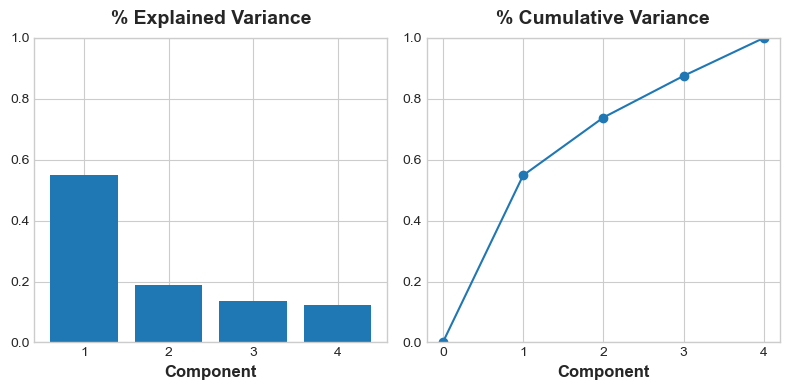

In [14]:
# Look at explained variance
plot_variance(pca);

Also look at the MI scores of the components. You should see a more informative component than the others, though the remaining components, despite their small variance, still have a significant relationship with the target.
Examining those components could be wothwhile to find relationships not captured by the main axis.

In [15]:
mi_scores = make_mi_scores(X_pca, y)
mi_scores

PC1    0.830680
PC2    0.225699
PC3    0.178745
PC4    0.051648
Name: MI Scores, dtype: float64

The smallest component sholud show a contrast between features (let say feature1 and feature2). 

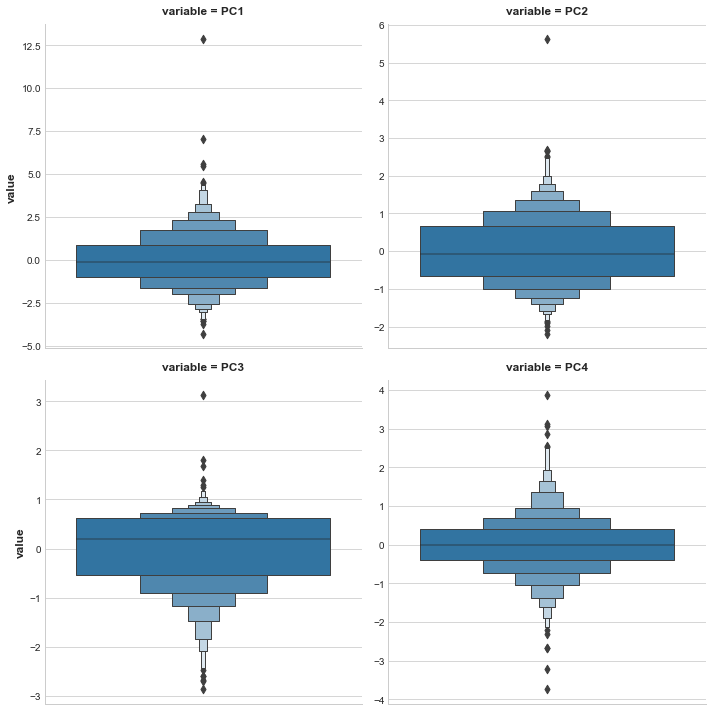

In [18]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [16]:
# Show dataframe sorted by a PC
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1298,160000,Edwards,Partial,1418,2008,6110,5642
523,184750,Edwards,Partial,884,2008,3138,4676
1182,745000,NoRidge,Abnorml,813,1996,2396,4476
691,755000,NoRidge,Normal,832,1995,2444,4316
496,430000,NoRidge,Normal,546,1993,3200,3228
...,...,...,...,...,...,...,...
1179,93000,Edwards,Normal,0,1954,0,1124
636,60000,BrkSide,Normal,0,1950,264,800
705,55000,IDOTRR,Normal,0,1950,0,1092
1218,80500,BrkSide,Normal,0,1950,0,912


To express the contrast, let's create a new ratio feature:

In [17]:
X = df.copy()
y = X.pop("SalePrice")

# Add new features to X.
#X["feature1"] = X.GrLivArea + X.TotalBsmtSF   
#X["feature2"] = X.YearRemodAdd + X.TotalBsmtSF
X = X.join(X_pca)

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.14618 RMSLE
